# Capstone Project: Find the Senior Apartments with the Best Quality of Life in Chicago

Peter Li

## Part 1. Import All Necessary Packages

In [1]:
import pandas as pd
from pandas.io.json import json_normalize
import folium
import json
%matplotlib inline
import requests

## Part 2. Import Affordable Housing Data

In [2]:
affordable_housing = pd.read_csv('Affordable_Rental_Housing_Developments.csv')

Filter the senior apartments in the raw data of all affordable rental housing developments in Chicago, and find the top 20 communities where the senior apartments are located in

In [3]:
senior_lst = ['Senior']

In [4]:
affordable_senior = affordable_housing[affordable_housing['Property Type'].isin(senior_lst)]

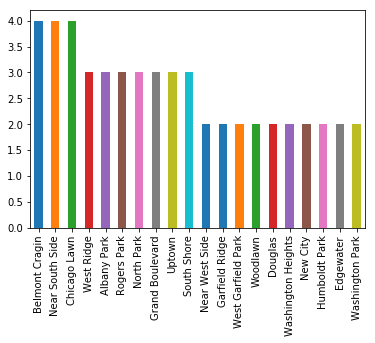

In [5]:
affordable_senior['Community Area Name'].value_counts()[:20].plot.bar()

## Part 3. Visualization of the Senior Apartments

Hard-code the geographic coordinate of Chicago, as well as the parameters of the Foursquare API, whose data will be aggregated later

In [6]:
chi_lat = 41.8781
chi_long = -87.6298
CLIENT_ID = 'XPX20NXJVLQ5IDWHMQHMEE31TKLJTT0NHQLZPI4YR2DFVZKU'
CLIENT_SECRET = 'DMV3SPUNKVCYFFW3VFQVDYM4EMU455CVR5S00JJ55WAT0OCY'
VERSION = '20180604'
radius = 500
LIMIT = 5

Visualize the locations of all senior apartments in Chicago

In [53]:
housing_map = folium.Map(location=[chi_lat, chi_long], zoom_start=11)
for index, row in affordable_senior.iterrows():
    folium.Marker([row['Latitude'], row['Longitude']],
                  popup=row['Property Name']).add_to(housing_map)

In [54]:
housing_map

## Part 4. Call Foursquare API and Import Data

Create the function that finds the nearest 5 venues of a given apartment complex

In [9]:
def find_venues(name, lat, long):
    
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    lat, 
    long, 
    radius, 
    LIMIT)
    results = requests.get(url).json()
    venues_df = pd.DataFrame(columns=['Property_Name', 'Venue_ID', 'Venue_Name', 'Venue_Category', 'Venue_LAT', 'Venue_LNG'])
    venues = results['response']['groups'][0]['items']
    for venue in venues:
        venues_df = venues_df.append({'Property_Name': name, 'Venue_ID': venue['venue']['id'], 'Venue_Name': venue['venue']['name'],
                                  'Venue_Category': venue['venue']['categories'][0]['name'],
                                  'Venue_LAT': venue['venue']['location']['lat'],
                                  'Venue_LNG': venue['venue']['location']['lng']}, ignore_index=True)
    return venues_df

Import the data from Foursquare API

In [10]:
data = pd.DataFrame(columns=['Property_Name', 'Venue_ID', 'Venue_Name', 'Venue_Category', 'Venue_LAT', 'Venue_LNG'])

In [11]:
for index, row in affordable_senior.iterrows():
    name = row['Property Name']
    lat = row['Latitude']
    long = row['Longitude']
    venues_df = find_venues(name, lat, long)
    data = pd.concat([venues_df, data], axis = 0)

In [12]:
data = data.reset_index(drop=True)

View the structure of our collected data

In [14]:
data[:10]

,Property_Name,Venue_ID,Venue_Name,Venue_Category,Venue_LAT,Venue_LNG
0,Roosevelt Towers,4dff9d28b0fbc94d43e4f035,PNC Bank,Bank,41.866680,-87.709760
1,Roosevelt Towers,5022a4a1e4b0cff4e8e4bc1d,Taco Bell,Fast Food Restaurant,41.866640,-87.710445
2,Roosevelt Towers,4e9dc4bef9f494d561c6c2be,Homan Square Park,Park,41.869896,-87.714801
3,Roosevelt Towers,4f5bf351e4b0a61f4b9c50f4,Rothchild Liquors,Liquor Store,41.866409,-87.714532
4,Roosevelt Towers,583df734964d7861b248bc44,Homan and Roosevelt,Intersection,41.866344,-87.710556
5,James Sneider Apts.,505d49ede4b0236a27575f1b,Sol Café,Café,42.019306,-87.672078
6,James Sneider Apts.,4b8f31aaf964a520364d33e3,GameStop,Video Game Store,42.018937,-87.674203
7,James Sneider Apts.,4b7f2fe7f964a520871d30e3,Ethiopian Diamond,African Restaurant,42.018801,-87.675930
8,James Sneider Apts.,51d9a63d498ee58cf68f7444,R Public House,Sports Bar,42.016032,-87.668571
9,James Sneider Apts.,4c4c3c56712ac9284337096e,Pete's Grill,Breakfast Spot,42.019096,-87.673544


Visualize the nearby venues of a given senior apartment complex on map

In [28]:
example_name = 'Roosevelt Towers'
example_lat = affordable_senior[affordable_senior['Property Name'] == example_name].iloc[0]['Latitude']
example_lng = affordable_senior[affordable_senior['Property Name'] == example_name].iloc[0]['Longitude']
example_map = folium.Map(location=[example_lat, example_lng], zoom_start=15)
folium.Marker([example_lat, example_lng], popup=example_name).add_to(example_map)
example_venues = data[data['Property_Name'] == example_name]
for index, row in example_venues.iterrows():
    folium.CircleMarker(
    [row['Venue_LAT'], row['Venue_LNG']],
    radius=10,
    color='blue',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6,
    popup=row['Venue_Name']).add_to(example_map)

In [29]:
example_map

## Part 5. Find the Rated Scores of the Venues Nearby

Create the function that gets the score of a specific venue

In [30]:
def get_score(venue_id):
    url2 = 'https://api.foursquare.com/v2/venues/{0}'.format(venue_id)
    params = dict(
    client_id=CLIENT_ID,
    client_secret=CLIENT_SECRET,
    v='20180604'
    )
    score = 'NA'
    r = requests.get(url2, params).json()
    if 'venue' in r['response'].keys():
        if 'rating' in r['response']['venue'].keys():
            score = r['response']['venue']['rating']
    
    return score

Find the score of every venue in our dataset

In [31]:
data['Score'] = data['Venue_ID'].apply(lambda x: get_score(x))

In [32]:
data_filtered = data[data['Score'] != 'NA'].reset_index(drop=True)

In [33]:
data_filtered['Score'] = data_filtered['Score'].astype('float64')

Find the average score of the venues near every available apartment complex

In [34]:
data_filtered.groupby(['Property_Name'])['Score'].mean()

Property_Name
Hilliard Homes Phase I            8.260000
James Sneider Apts.               8.080000
Midway Pointe Senior Living       6.525000
North & Pulaski Senior Housing    7.860000
Pioneer Village Apts.             7.960000
Roosevelt Towers                  6.900000
Senior Suites of Chatham          7.600000
Senior Suites of Rainbow Beach    7.066667
The Kilpatrick Renaissance        8.060000
Wayne Senior Housing              8.660000
Name: Score, dtype: float64

In [36]:
quality_score = data_filtered.groupby('Property_Name')['Score'].mean().reset_index()

In [38]:
quality_score.sort_values(by='Score', ascending=False)

,Property_Name,Score
9,Wayne Senior Housing,8.660000
0,Hilliard Homes Phase I,8.260000
1,James Sneider Apts.,8.080000
8,The Kilpatrick Renaissance,8.060000
4,Pioneer Village Apts.,7.960000
3,North & Pulaski Senior Housing,7.860000
6,Senior Suites of Chatham,7.600000
7,Senior Suites of Rainbow Beach,7.066667
5,Roosevelt Towers,6.900000
2,Midway Pointe Senior Living,6.525000


Find the apartment complex information with the available scores

In [40]:
affordable_senior[affordable_senior['Property Name'].isin(quality_score['Property_Name'])]

,Community Area Name,Community Area Number,Property Type,Property Name,Address,Zip Code,Phone Number,Management Company,Units,X Coordinate,Y Coordinate,Latitude,Longitude,Location,Historical Wards 2003-2015,Wards,Community Areas,Zip Codes,Census Tracts
341,Rogers Park,1,Senior,Wayne Senior Housing,6928 N. Wayne Ave.,60626,773-274-0177,CIG Management,119,1.165844e+06,1.946059e+06,42.007574,-87.665171,"(42.0075737709, -87.6651711448)",3,5,10,21853,66
344,Portage Park,15,Senior,The Kilpatrick Renaissance,4655 W. Burteau Ave.,60641,773-283-4655,The Renaissance Cos.,98,1.144212e+06,1.927250e+06,41.956396,-87.745236,"(41.9563963216, -87.7452358895)",20,50,15,22618,139
350,Chatham,44,Senior,Senior Suites of Chatham,8300 S. Cottage Grove Ave.,60619,773-488-1333,Senior Lifestyle Corp.,90,1.182965e+06,1.850099e+06,41.743874,-87.605176,"(41.743873821, -87.6051761606)",31,32,40,21546,140
351,South Shore,43,Senior,Senior Suites of Rainbow Beach,2804 E. 77th Place,60649,773-374-5333,Senior Lifestyle Corp.,87,1.196632e+06,1.854159e+06,41.754687,-87.554965,"(41.7546866025, -87.5549647165)",43,37,39,22538,421
357,Garfield Ridge,56,Senior,Midway Pointe Senior Living,5011 W. 47th St.,60638,872-302-4010,Perlmark Realty Management LLC,85,1.143676e+06,1.872964e+06,41.807441,-87.748567,"(41.8074412435, -87.748566779)",35,28,53,22268,605
362,Near South Side,33,Senior,Hilliard Homes Phase I,30 W. Cermak Road,60616,312-326-1455,Holsten Real Estate Dev. Corp.,151,1.176346e+06,1.889817e+06,41.853013,-87.628232,"(41.8530133902, -87.628232211)",12,9,34,21194,330
371,Douglas,35,Senior,Pioneer Village Apts.,340 E. 38th St.,60653,773-536-0463,Pioneer Affordable Housing Preservation,152,1.179348e+06,1.879907e+06,41.825753,-87.617517,"(41.8257532207, -87.6175174282)",12,9,1,4301,222
373,Humboldt Park,23,Senior,North & Pulaski Senior Housing,3939-59 W. North Ave.,60647,773-687-0234,Hispanic Housing Dev. Corp.,72,1.149678e+06,1.910302e+06,41.909787,-87.725582,"(41.9097870143, -87.7255819184)",27,49,24,22535,454
379,Rogers Park,1,Senior,James Sneider Apts.,7450 N. Rogers Ave.,60626,773-743-3699,Hispanic Housing Dev. Corp.,57,1.163641e+06,1.949531e+06,42.017150,-87.673179,"(42.0171497111, -87.6731785733)",3,5,10,21853,489
385,North Lawndale,29,Senior,Roosevelt Towers,3440 W. Roosevelt Road,60624,773-265-6961,"East Lake Management Group, Inc.",104,1.153440e+06,1.894533e+06,41.866440,-87.712181,"(41.8664397713, -87.7121808603)",36,14,30,21572,98


Visualize the apartments with different average score on map

In [49]:
score_map = folium.Map(location=[chi_lat, chi_long], zoom_start=11)
for index, row in affordable_senior[affordable_senior['Property Name'].isin(quality_score['Property_Name'])].iterrows():
    if quality_score[quality_score['Property_Name'] == row['Property Name']].iloc[0]['Score'] > 8.0:
        folium.CircleMarker([row['Latitude'], row['Longitude']],
                            color='blue',
                            fill_color='blue',
                            popup=
                            ', Score: '.join((row['Property Name'], 
                            quality_score[quality_score['Property_Name'] == row['Property Name']].iloc[0]['Score'].astype('str')))).add_to(score_map)
    elif (quality_score[quality_score['Property_Name'] == row['Property Name']].iloc[0]['Score'] > 7.0) & (quality_score[quality_score['Property_Name'] == row['Property Name']].iloc[0]['Score'] <= 8.0):
        folium.CircleMarker([row['Latitude'], row['Longitude']],
                      color='orange',
                      fill_color='orange',
                      popup=
                      ', Score: '.join((row['Property Name'], 
                       quality_score[quality_score['Property_Name'] == row['Property Name']].iloc[0]['Score'].astype('str')))).add_to(score_map)
    else:
        folium.CircleMarker([row['Latitude'], row['Longitude']],
                      color='red',
                      fill_color='red',
                      popup=
                      ', Score: '.join((row['Property Name'], 
                       quality_score[quality_score['Property_Name'] == row['Property Name']].iloc[0]['Score'].astype('str')))).add_to(score_map)

In [50]:
score_map